# Running experiments

## Mozaik

Read the [Mozaik README](https://github.com/CSNG-MFF/mozaik) for installation and how to run Mozaik experiments locally on your computer.

## Running experiments through Slurm
To run the model through Slurm (which we use to schedule jobs on the cluster), run:

`python run_model_slurm.py run.py nest param/defaults`

You can see the jobs currently running on the cluster with `squeue`, summarized info about jobs with `sinfo`, and cancel your jobs with `scancel job_id` (e.g. `scancel 237444`). Naturally, you can only cancel your own jobs. 

The script `run_model_slurm.py` has several useful options for setting up the Slurm job to run the experiment. I mostly only change the job name, and the `--exclude` parameter, where you can specify where your job should not run. If you know you'll be running a job that takes a long time (4h+), please schedule it such that you'll leave a node or so empty, unless it's the evening or the weekend.

## Modifying the experiments

You can modify the basic runscript in `run.py`, and the experiment parameters in `experiments.py`. 

At first, try to limit your run to only a few images! Because of the structure of the Mozaik framework, all the numpy arrays with the optogenetic stimulation data are generated before any experiment is run, and thus the runs can be quite memory intensive.

## Changing model parameters

If you'll need to, you can change the model parameters dynamically in the `run_model_slurm.py` file. As an example, you can do:
```
CombinationParameterSearch(
    SlurmSequentialBackend(
        num_threads=16,
        num_mpi=1,
        path_to_mozaik_env="/home/rozsa/virt_env/mozaik/bin/activate",
        slurm_options=slurm_options,
    ),  
    {   
        'pynn_seed': [520,1024,2240],
    },
).run_parameter_search()
```

Then the model will run 3x in parallel with the same experiment, but with different random seeds. To access nested parameters, use this notation: `'sheets.l4_cortex_exc.params.cell.params.tau_m': [8,9]`

# Viewing experiment results

## Results folder
The results are stored in folder with following the naming format:

```
datetime[parameter_dir_name]CombinationParamSearch{parameter_names_and_values}/
modelname_ParameterSearch_____paramname1:paramvalue_paramname2:paramvalue
```

For example: 
```
20230131-135335[param.defaults]CombinationParamSearch{trial:[1]}/
SelfSustainedPushPull_ParameterSearch_____trial:1
```

## Run log

The log file of the run is stored in the main result folder under the name `slurm_jobid.out`:

`20230131-135335[param.defaults]CombinationParamSearch{trial:[1]}/slurm_237566.out`

This will contain all logging messages from the run, as well as any errors that happened during it. If your run is successful, the end of your log file should look something like this:

```
0    Stimulus 1/1 finished. Memory usage: 12825MB
0    Experiment 1/1 finished
0    Total simulation run time: 118s
0    Simulator run time: 73s (62%) 
0    Mozaik run time: 44s (37%) 
```

## Reading experiment data

In [1]:
from mozaik.storage.datastore import PickledDataStore
from parameters import ParameterSet
from mozaik.storage.queries import param_filter_query
from mozaik.tools.distribution_parametrization import load_parameters
import logging
import sys
from mozaik.storage.queries import *
from mozaik.analysis.analysis import *
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
from mozaik.storage.datastore import DataStoreView
import matplotlib.pyplot as plt
import numpy as np

# Path to the experiment DataStore
# Substitute this path with the path of your own run!
#path = "20230203-174506[param.defaults]CombinationParamSearch{trial:[1]}/SelfSustainedPushPull_ParameterSearch_____trial:1"
path = "SelfSustainedPushPull_ParameterSearch_____base_weight:0.00026_base_weight:0.0016_tau_rec:100_sigma:1.3_base_weight:0.00022_AfferentMean:42/"

data_store = PickledDataStore(
    load=True,
    parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
    replace=False,
)

In [2]:
# Some example analysis
psth_bin_length = 50
data_store.full_datastore.remove_ads_from_datastore()
PSTH(data_store,ParameterSet({'bin_length': psth_bin_length})).analyse()

TrialMean(
    param_filter_query(data_store.full_datastore, analysis_algorithm="PSTH"),
    ParameterSet({"vm": False, "cond_inh": False, "cond_exc": False}),
).analyse()

INFO:Mozaik:Starting PSTH analysis
INFO:Mozaik:Starting TrialMean analysis




Layer: V1_Exc_L4

DataStoreView contents:
INFO:Mozaik:DSV info:
INFO:Mozaik:   Number of recordings: 20
INFO:Mozaik:     NaturalImageWithEyeMovement : 20
INFO:Mozaik:   Number of ADS: 11
INFO:Mozaik:     AnalogSignalList : 11

Example of a single stimulus:
 {"module_path" :"mozaik.stimuli.vision.topographica_based","background_luminance":50.0, "density":20.0, "direct_stimulation_name":None, "direct_stimulation_parameters":None, "duration":2002, "eye_movement_period":6.66, "eye_path_location":'./eye_path.pickle', "frame_duration":7.0, "image_location":'./image_naturelle_HIGHC.bmp', "location_x":0.0, "location_y":0.0, "name":'NaturalImageWithEyeMovement', "size":30, "size_x":11.0, "size_y":11.0, "trial":0}


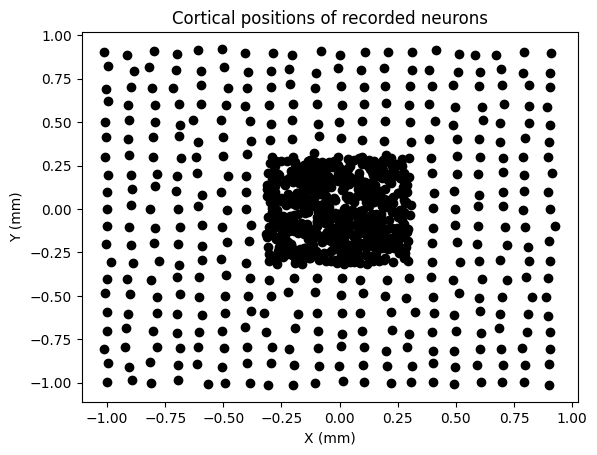

(3, 881)
881


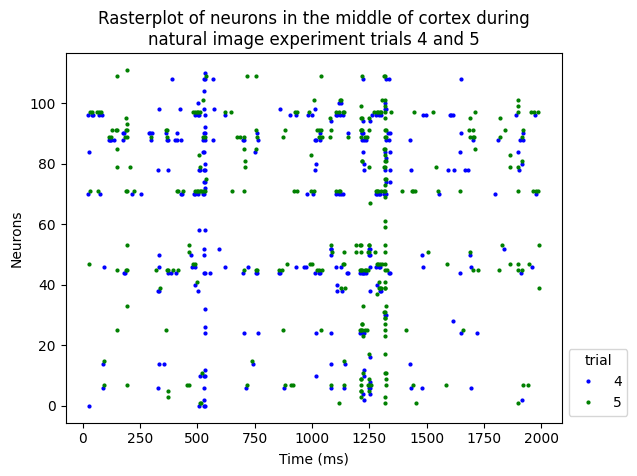

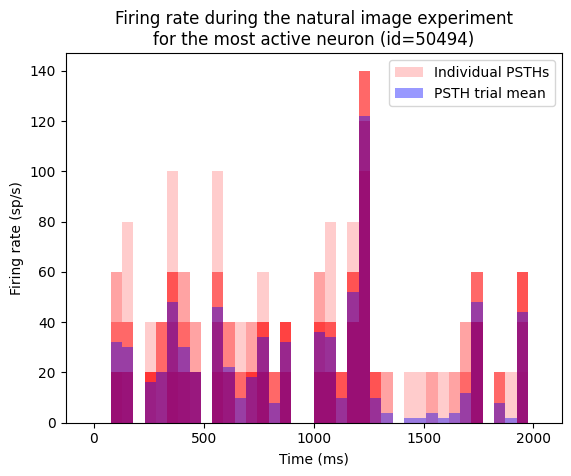



Layer: V1_Exc_L2/3

DataStoreView contents:
INFO:Mozaik:DSV info:
INFO:Mozaik:   Number of recordings: 20
INFO:Mozaik:     NaturalImageWithEyeMovement : 20
INFO:Mozaik:   Number of ADS: 11
INFO:Mozaik:     AnalogSignalList : 11

Example of a single stimulus:
 {"module_path" :"mozaik.stimuli.vision.topographica_based","background_luminance":50.0, "density":20.0, "direct_stimulation_name":None, "direct_stimulation_parameters":None, "duration":2002, "eye_movement_period":6.66, "eye_path_location":'./eye_path.pickle', "frame_duration":7.0, "image_location":'./image_naturelle_HIGHC.bmp', "location_x":0.0, "location_y":0.0, "name":'NaturalImageWithEyeMovement', "size":30, "size_x":11.0, "size_y":11.0, "trial":5}


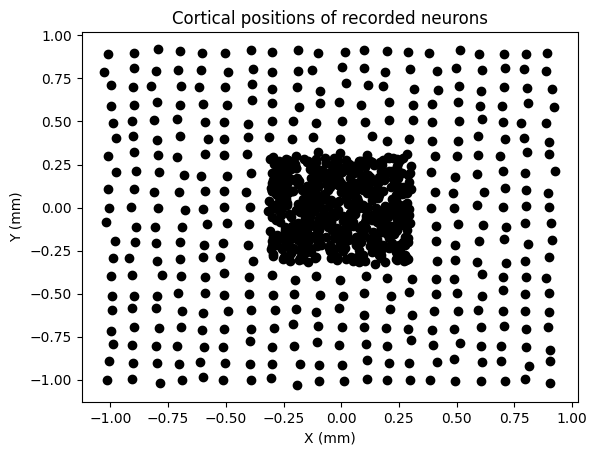

(3, 873)
873


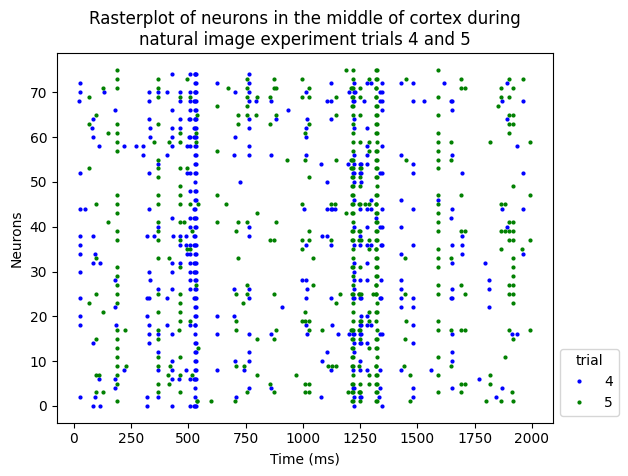

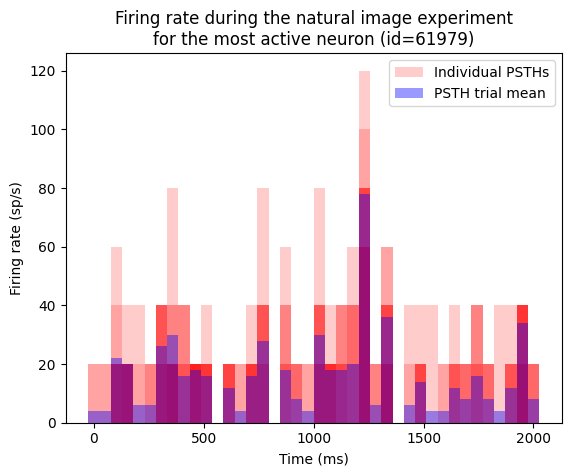

In [3]:
excitatory_cortical_layers = ["V1_Exc_L4", "V1_Exc_L2/3"]

# Some example analysis and plots
for sheet in excitatory_cortical_layers:
    # We can query the DataStore for the results we want
    # It returns a DataStoreView, a slice of the DataStore
    # Here we want the slice of the datastore that has recordings of
    # the natural image experiment, in the cortical layer we are looking at
    print("\n\nLayer: %s\n" % sheet)
    dsv = param_filter_query(
        data_store, st_name="NaturalImageWithEyeMovement", sheet_name=sheet
    )
    print("DataStoreView contents:")
    dsv.print_content()
    print("\nExample of a single stimulus:\n", dsv.get_stimuli()[0])

    # Get ids of neurons where spike trains were recorded in the sheet
    st_ids = [s for s in dsv.get_segments() if len(s.spiketrains) > 0][
        0
    ].get_stored_spike_train_ids()

    # Retrieve and plot x,y positions of recorded neurons
    pos = dsv.get_neuron_positions()[sheet][:, dsv.get_sheet_indexes(sheet, st_ids)]
    plt.title("Cortical positions of recorded neurons")
    plt.plot(pos[0, :], pos[1, :], "ok")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.show()

    # Plot spike times for neurons near the middle of the cortex for trials 4 and 5 in the natural image experiment
    # Retrieve spike times
    dsv_trial5 = param_filter_query(dsv, st_trial=[4, 5])
    segments = dsv_trial5.get_segments()
    spiketimes = [seg.get_spiketrains() for seg in segments]
    # Get which ids are near the middle of the cortex
    dist = np.sqrt(pos[0, :] ** 2 + pos[1, :] ** 2)
    select_ids = np.where(dist < 0.1)[0]  # 0.1 mm radius
    # Get spiketimes for these ids
    filtered_spiketimes = [[st[s_id] for s_id in select_ids] for st in spiketimes]
    # Plot
    legend_labels = ["4", "5"]
    for i in range(len(filtered_spiketimes)):
        for j in range(len(filtered_spiketimes[i])):
            color = "b" if i == 0 else "g"
            label = legend_labels[i] if j == 0 else None
            plt.plot(
                filtered_spiketimes[i][j],
                np.ones(len(filtered_spiketimes[i][j])) * j * 2 + i,
                "o",
                color=color,
                label=label,
                ms=2,
            )
    plt.title(
        "Rasterplot of neurons in the middle of cortex during\nnatural image experiment trials 4 and 5"
    )
    plt.legend(title="trial", bbox_to_anchor=(1, 0), loc="lower left")
    plt.xlabel("Time (ms)")
    plt.ylabel("Neurons")
    plt.show()

    # Retrieve PSTH (Peristimulus Timing Histogram) analysis results
    psths_ar = dsv.get_analysis_result(
        analysis_algorithm="PSTH",
        sheet_name=sheet,
        y_axis_name="psth (bin=%d)" % psth_bin_length,
    )
    mean_psth_ar = dsv.get_analysis_result(
        analysis_algorithm="TrialMean",
        sheet_name=sheet,
        y_axis_name="psth (bin=%d) trial-to-trial mean" % psth_bin_length,
    )[0]

    # Plot the PSTHs, and mean PSTH of the neuron with the largest mean activity
    idx = np.argmax(np.sum(np.array(mean_psth_ar.asl).squeeze(), axis=1))
    n_id = mean_psth_ar.ids[idx]
    mean_psth = mean_psth_ar.asl[idx].squeeze()
    psths = [
        psth.asl[np.where(np.array(psths_ar[0].ids) == n_id)[0][0]].squeeze()
        for psth in psths_ar
    ]
    a = mean_psth
    t = np.linspace(0, psth_bin_length * len(a), len(a), endpoint=True)
    first = True
    for aa in psths:
        label = None
        if first:
            label = "Individual PSTHs"
            first = False
        plt.bar(t, aa, width=(t[1] - t[0]), color="r", alpha=0.2, label=label)
    plt.bar(t, a, width=(t[1] - t[0]), color="b", label="PSTH trial mean", alpha=0.4)
    plt.title(
        "Firing rate during the natural image experiment\nfor the most active neuron (id=%d)"
        % n_id
    )
    plt.xlabel("Time (ms)")
    plt.ylabel("Firing rate (sp/s)")
    plt.legend()
    plt.show()